**Najdi funkci $u$ na oblasti $\Omega = (0, 1) \times (0, 1)$ splňující:**
$$\begin{align*}
    -\Delta u &= f \qquad \text{na } \Omega \\
    u &= 0 \qquad \text{na } \partial\Omega
\end{align*}$$

**Přesné řešení:**\
Položme $u(x,y) = x(1-x)y(1-y)$. Snadno se ověří, že $u(x, y) = 0$ na $\partial\Omega$. Spočtěme Laplacián:
$$\begin{equation*}
    \Delta u = 2(x^2 + y^2 - x - y).
\end{equation*}$$
Volme funkci $f$ právě takto:
$$\begin{equation*}
    f(x, y) = -2(x^2 + y^2 - x - y).
\end{equation*}$$
Z toho je již však vidno, že dvojice $u, f$ je přesným řešením úlohy. \
Níže budeme trénovat model řešící tuto úlohu, a poté jej porovnáme s přesným řešením.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Zakladni import
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import sys

In [3]:
# Import vlastnich modulu
sys.path.append('../')
from src.models.mlp_model import MLPModel
import src.data.square_domain as sq
from src import train
from src import calculus as calc
from src import utils

In [4]:
# Volba vhodneho device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# definice funkce f(x, y)
def f(x: torch.Tensor) -> torch.Tensor:
    return -2 * (x[:, 0:1]**2 + x[:, 1:2]**2 - x[:, 0:1] - x[:, 1:2])

In [6]:
# Definice ztratove funkce
def loss_fn(model: nn.Module, domain: sq.SquareDomain) -> torch.Tensor:
    _, _, _, _, _, u_lapl = calc.laplacian_2d(model, domain.interior)
    f_vals = f(domain.interior)
    inner_loss = torch.mean((u_lapl + f_vals) ** 2)
    
    total_bnd = torch.cat([domain.left_boundary,
                          domain.right_boundary,
                          domain.top_boundary,
                          domain.bottom_boundary], dim=0)

    u_bnd = model(total_bnd)
    bnd_loss = torch.mean((u_bnd) ** 2)

    return inner_loss + 2* bnd_loss

In [ ]:
# Definice modelu
model = MLPModel(input_dim=2, output_dim=1, hidden_dim=[50, 50, 50, 50, 50]).to(device)
# Definice domeny
config = sq.SquareDomainConfig(
    x_0=0,
    x_1=1,
    y_0=0,
    y_1=1,
    device=device,
    N_int=10_000,
    N_left=2_000,
    N_bottom=2_000,
    N_right=2_000,
    N_top=2_000,
    interior_strategy='latin',
    boundary_strategy='uniform'
)

domain = sq.SquareDomain(config)
# Definice optimizeru
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Definice scheduleru
scheduler = StepLR(optimizer, step_size=1000, gamma=0.1)

In [12]:
# Spusteni trenovani
context = train.TrainingContext(
    model=model,
    optimizer=optimizer,
    domain=domain,
    loss_fn=loss_fn,
    scheduler=scheduler,
    epochs=5_000,
)

loss_values = train.train_switch_to_lbfgs(ctx=context, lbfgs_lr=1e-3, epochs_with_lbfgs=500)

Loss at epoch 1 is: 0.4789852797985077
Loss at epoch 100 is: 0.017103519290685654
Loss at epoch 200 is: 0.008500654250383377
Loss at epoch 300 is: 0.002078709425404668
Loss at epoch 400 is: 0.0017854246543720365
Loss at epoch 500 is: 0.0015950181987136602
Loss at epoch 600 is: 0.0014936965890228748
Loss at epoch 700 is: 0.0014155106619000435
Loss at epoch 800 is: 0.0013634990900754929
Loss at epoch 900 is: 0.0012858737027272582
Loss at epoch 1000 is: 0.0012143146013841033
Loss at epoch 1100 is: 0.0011979993432760239
Loss at epoch 1200 is: 0.0011882284888997674
Loss at epoch 1300 is: 0.0012112746480852365
Loss at epoch 1400 is: 0.001197335310280323
Loss at epoch 1500 is: 0.0011951187625527382
Loss at epoch 1600 is: 0.0012226758990436792
Loss at epoch 1700 is: 0.0011729394318535924
Loss at epoch 1800 is: 0.0011466455180197954
Loss at epoch 1900 is: 0.00114539940841496
Loss at epoch 2000 is: 0.0011326231760904193
Loss at epoch 2100 is: 0.0011281926417723298
Loss at epoch 2200 is: 0.001154

/home/berva/Projects/PINNs/Introduction/notebooks/../src/utils.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels)


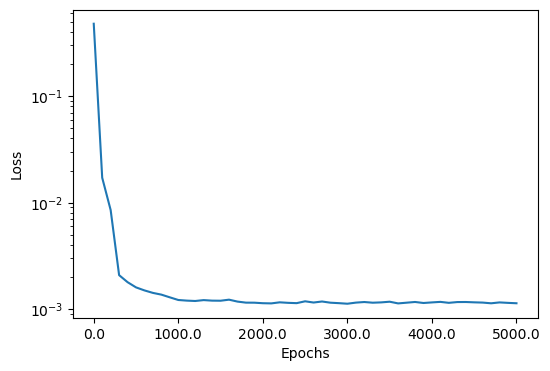

In [13]:
# Vykresleni ztraty
utils.plot_loss_values(loss_values, 'Epochs', 'Loss')

In [ ]:
# Kontrola vysledku
# prvne vykreslime trenovaci ztratu
def model_cut(x: torch.Tensor):
    return torch.relu(model(x))

plot_ctx = utils.PlotContext(
    function=model,
    domain=domain,
    patches=[],
    figsize=(5, 4)
)

utils.plot_function_on_domain(ctx=plot_ctx)

AttributeError: 'MLPModel' object has no attribute 'generate_points'

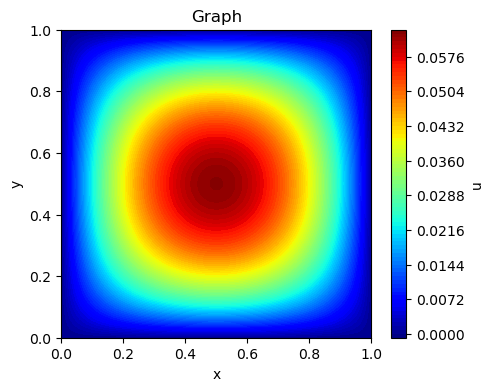

In [15]:
# Nyni vykreslime spravne reseseni
def u(x: torch.Tensor) -> torch.Tensor:
    return x[:, 0]*(1 - x[:, 0])*x[:, 1]*(1 - x[:, 1])

plot_ctx.function=u

utils.plot_function_on_domain(plot_ctx)